# Vehicle Routing Problem (VRP)
### Computational Intelligence for Optimization Project Notebook
Project by **Group 52**:
* Arda Kaykusuz | 20230766@novaims.unl.pt
* Arif Maharramov | 20230770@novaims.unl.pt
* Joana Ferreira | 20230193@novaims.unl.pt
* Yasmine Boubezari | 320230775@novaims.unl.pt

# Selection

In [1]:
def tournament_selection(population, k=3):
    selected = random.sample(population.individuals, k)
    return min(selected, key=lambda ind: ind.fitness) if population.optim == "min" else max(selected, key=lambda ind: ind.fitness)

def roulette_wheel_selection(population):
    max_fitness = sum(ind.fitness for ind in population.individuals)
    pick = random.uniform(0, max_fitness)
    current = 0
    for individual in population.individuals:
        current += individual.fitness
        if current > pick:
            return individual

def fps_selection(population):
    total_fitness = sum(ind.fitness for ind in population.individuals)
    probabilities = [ind.fitness / total_fitness for ind in population.individuals]
    return population.individuals[np.random.choice(len(population.individuals), p=probabilities)]

# Crossover

In [2]:
def group_based_crossover(parent1, parent2):
    child1, child2 = [], []
    group_size = random.randint(1, len(parent1)//2)
    for i in range(0, len(parent1), group_size):
        if random.random() > 0.5:
            child1.extend(parent1[i:i+group_size])
            child2.extend(parent2[i:i+group_size])
        else:
            child1.extend(parent2[i:i+group_size])
            child2.extend(parent1[i:i+group_size])
    return child1, child2

def eager_breeder_crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1)-2)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

def twin_maker_crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1)-1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2



# Mutation

In [3]:
def swap_mutation(individual):
    route = random.choice(individual)
    if len(route) > 1:
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]
    return individual

def merge_and_split_mutation(individual):
    if len(individual) > 1:
        route1, route2 = random.sample(individual, 2)
        if len(route1) > 1:
            split_point = random.randint(1, len(route1) - 1)
            new_route1 = route1[:split_point] + route2
            new_route2 = route1[split_point:]
            individual.remove(route1)
            individual.remove(route2)
            individual.append(new_route1)
            individual.append(new_route2)
    return individual


def hop_mutation(individual):
    if len(individual) > 1:
        route1, route2 = random.sample(individual, 2)
        if route1 and route2:
            customer = route1.pop(random.randrange(len(route1)))
            route2.insert(random.randrange(len(route2)), customer)
    return individual

def dream_team_mutation(individual):
    flattened = [customer for route in individual for customer in route]
    random.shuffle(flattened)
    new_individual = [flattened[i::len(individual)] for i in range(len(individual))]
    return new_individual


# Fitness function and evolution

Processing augerat\A-n32-k05.xml
Distance Matrix: [[  0.          34.92849839  77.87810989 ...  62.28964601  16.2788206
   72.78049189]
 [ 34.92849839   0.          60.30754513 ...  80.32434251  19.41648784
   39.05124838]
 [ 77.87810989  60.30754513   0.         ...  71.58910532  65.19202405
   48.        ]
 ...
 [ 62.28964601  80.32434251  71.58910532 ...   0.          65.76473219
  101.53324579]
 [ 16.2788206   19.41648784  65.19202405 ...  65.76473219   0.
   56.5154846 ]
 [ 72.78049189  39.05124838  48.         ... 101.53324579  56.5154846
    0.        ]]
Demands: [19.0, 21.0, 6.0, 19.0, 7.0, 12.0, 16.0, 6.0, 16.0, 8.0, 14.0, 21.0, 16.0, 3.0, 22.0, 18.0, 19.0, 1.0, 24.0, 8.0, 12.0, 4.0, 8.0, 24.0, 24.0, 2.0, 20.0, 15.0, 2.0, 14.0, 9.0]
Vehicle Capacity: 100.0
Best individual: [[18, 18], [24], [19], [25], [7]]
Fitness of best individual: 0.0
Processing augerat\A-n33-k05.xml
Distance Matrix: [[ 0.         45.45327271 14.56021978 ... 61.         29.52964612
  40.31128874]
 [45.45327

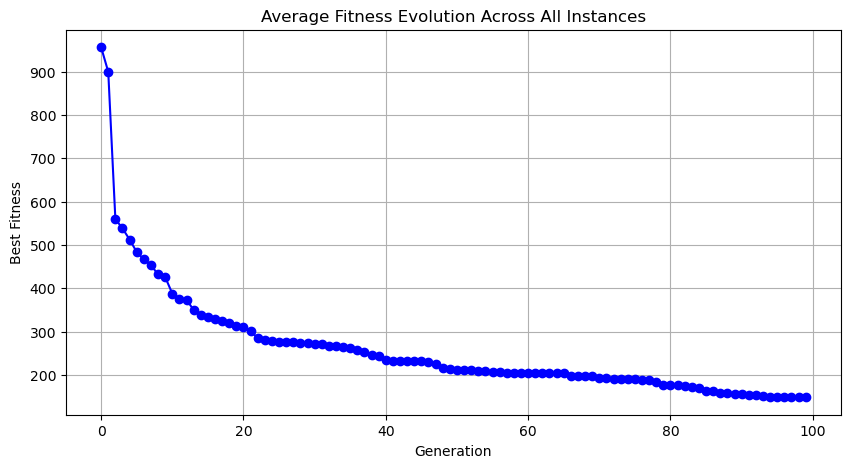

In [4]:
import os
import random
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define the fitness function
def fitness_function(individual, distance_matrix, demands, vehicle_capacity):
    total_distance = 0
    penalty = 0
    for route in individual:
        if len(route) > 1:
            try:
                route_distance = sum(distance_matrix[route[i]-1][route[i+1]-1] for i in range(len(route) - 1))
                route_distance += distance_matrix[route[-1]-1][route[0]-1]  # Return to depot
                route_demand = sum(demands[customer-1] for customer in route)
                if route_demand > vehicle_capacity:
                    penalty += 1000 * (route_demand - vehicle_capacity)
                total_distance += route_distance
            except IndexError as e:
                print(f"IndexError: {e}")
                print(f"Route causing error: {route}")
                raise e
    return total_distance + penalty

# XML Parsing Function
def parse_vrp_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    nodes = {}
    demands = []
    coordinates = []

    for node in root.find('network').find('nodes'):
        id = int(node.attrib['id'])
        x = float(node.find('cx').text)
        y = float(node.find('cy').text)
        nodes[id] = (x, y)
        coordinates.append((x, y))

    for request in root.find('requests'):
        demands.append(float(request.find('quantity').text))

    vehicle_capacity = float(root.find('fleet').find('vehicle_profile').find('capacity').text)

    num_customers = len(nodes)
    distance_matrix = np.zeros((num_customers, num_customers))

    for i in range(num_customers):
        for j in range(num_customers):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))

    return distance_matrix, demands, vehicle_capacity

# Route generation function to avoid duplicates
def generate_routes(num_routes, max_stops, num_stops):
    routes = set()
    while len(routes) < num_routes:
        route_length = random.randint(1, max_stops)
        route = tuple(sorted(random.sample(range(1, num_stops + 1), route_length)))
        routes.add(route)
    return [list(route) for route in routes]

# Define the Individual and Population classes
class Individual:
    def __init__(self, representation=None, size=None, valid_set=None, repetition=True):
        if representation is None:
            self.representation = self.create_random_routes(size, valid_set)
        else:
            self.representation = representation
        self.fitness = self.get_fitness()

    def create_random_routes(self, size, valid_set):
        """Create random routes for the initial population"""
        routes = generate_routes(size, len(valid_set)//size, len(valid_set))
        return routes

    def get_fitness(self):
        raise Exception("You need to monkey patch the fitness function.")

    def __len__(self):
        return len(self.representation)

    def __getitem__(self, position):
        return self.representation[position]

    def __setitem__(self, position, value):
        self.representation[position] = value

    def __repr__(self):
        return f"Fitness: {self.fitness}"

class Population:
    def __init__(self, size, optim, **kwargs):
        self.size = size
        self.optim = optim
        self.individuals = [
            Individual(size=kwargs["sol_size"], valid_set=kwargs["valid_set"], repetition=kwargs["repetition"])
            for _ in range(size)
        ]
        self.fitness_history = []  # To track the best fitness value in each generation

    def evolve(self, gens, select, crossover, mutate, co_p, mu_p, elitism):
        for gen in range(gens):
            new_pop = []

            if elitism:
                elite = min(self.individuals, key=lambda ind: ind.fitness) if self.optim == "min" else max(self.individuals, key=lambda ind: ind.fitness)
                new_pop.append(elite)

            while len(new_pop) < self.size:
                parent1 = select(self)
                parent2 = select(self)

                if random.random() < co_p:
                    offspring1, offspring2 = crossover(parent1.representation, parent2.representation)
                else:
                    offspring1, offspring2 = parent1.representation, parent2.representation

                if random.random() < mu_p:
                    offspring1 = mutate(offspring1)
                if random.random() < mu_p:
                    offspring2 = mutate(offspring2)

                new_pop.append(Individual(representation=offspring1))
                new_pop.append(Individual(representation=offspring2))

            self.individuals = new_pop[:self.size]
            
            # Track the best fitness value in this generation
            best_fitness = min(self.individuals, key=lambda ind: ind.fitness).fitness if self.optim == "min" else max(self.individuals, key=lambda ind: ind.fitness).fitness
            self.fitness_history.append(best_fitness)

    @property
    def best_solution(self):
        return min(self.individuals, key=lambda ind: ind.fitness) if self.optim == "min" else max(self.individuals, key=lambda ind: ind.fitness)

# Patch the fitness function
Individual.get_fitness = lambda self: fitness_function(self.representation, distance_matrix, demands, vehicle_capacity)

# Example selection, crossover, and mutation functions
def select(population):
    return random.choice(population.individuals)

def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1)-1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

def mutate(individual):
    route = random.choice(individual)
    if len(route) > 1:
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]
    return individual

# Function to visualize fitness evolution
def plot_fitness_evolution(fitness_history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, marker='o', linestyle='-', color='b')
    plt.title(title)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.show()

# Get all XML files in the 'augerat' directory
folder_path = 'augerat'
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.xml')]

# Process multiple instances and track average fitness
all_fitness_histories = []
best_fitness_values = []

for file_path in file_paths:
    distance_matrix, demands, vehicle_capacity = parse_vrp_xml(file_path)
    print(f"Processing {file_path}")
    print("Distance Matrix:", distance_matrix)
    print("Demands:", demands)
    print("Vehicle Capacity:", vehicle_capacity)

    # Ensure valid_set is within range
    valid_set = list(range(1, len(distance_matrix)))

    # Initialize the population
    population = Population(
        size=10,
        optim="min",
        sol_size=5,  # Assume 5 vehicles for the routes
        valid_set=valid_set,
        repetition=True
    )

    # Evolve the population
    population.evolve(
        gens=100,          # Number of generations
        select=tournament_selection,     # Selection function
        crossover=group_based_crossover,  # Crossover function
        mutate=dream_team_mutation,     # Mutation function
        co_p=0.8,          # Crossover probability
        mu_p=0.2,          # Mutation probability
        elitism=True       # Elitism to keep the best individual
    )

    # Track fitness history for this instance
    all_fitness_histories.append(population.fitness_history)

    # Get the best solution
    best_individual = population.best_solution
    best_fitness_values.append(best_individual.fitness)
    print("Best individual:", best_individual.representation)
    print("Fitness of best individual:", best_individual.fitness)

# Calculate average fitness history across all instances
min_length = min(len(history) for history in all_fitness_histories)
truncated_histories = [history[:min_length] for history in all_fitness_histories]
average_fitness_history = np.mean(truncated_histories, axis=0)

# Calculate the average fitness of the best solutions
average_best_fitness = np.mean(best_fitness_values)
print("Average fitness of the best solutions:", average_best_fitness)

# Plot the average fitness evolution
plot_fitness_evolution(average_fitness_history, 'Average Fitness Evolution Across All Instances')


# Performance of different method combinations

Elitism: True, Selection Method: tournament, Average Fitness: 732.2239002075629
Elitism: True, Selection Method: roulette, Average Fitness: 3206.6150038720834
Elitism: True, Selection Method: fps, Average Fitness: 3188.493330161796
Elitism: True, Mutation Method: swap, Average Fitness: 2949.739566456499
Elitism: True, Mutation Method: merge_and_split, Average Fitness: 2432.0801878345624
Elitism: True, Mutation Method: hop, Average Fitness: 2577.4009129496344
Elitism: True, Mutation Method: dream_team, Average Fitness: 1543.8889784145613
Elitism: True, Crossover Method: group_based, Average Fitness: 2144.4221893344125
Elitism: True, Crossover Method: eager_breeder, Average Fitness: 2525.512591996219
Elitism: True, Crossover Method: twin_maker, Average Fitness: 2457.397452910812

Best Combination for Elitism = True:
Selection: tournament, Crossover: group_based, Mutation: merge_and_split, Average Fitness: 261.2080125646778


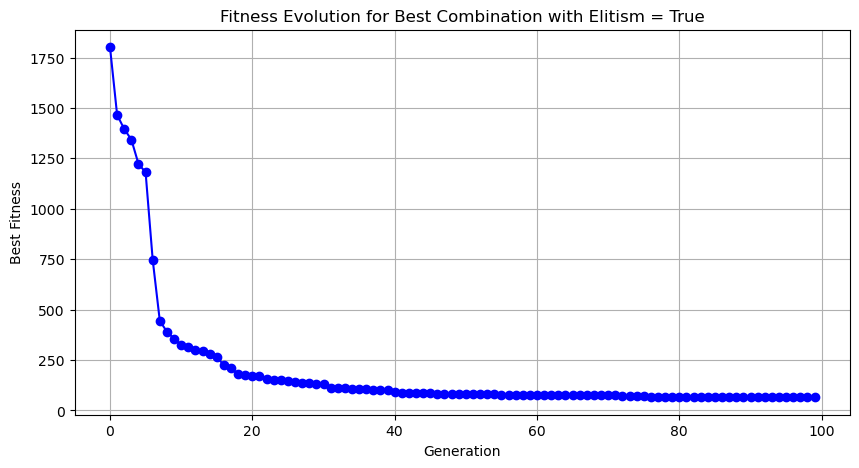

Elitism: False, Selection Method: tournament, Average Fitness: 7127.880600705186
Elitism: False, Selection Method: roulette, Average Fitness: 736675.8423282024
Elitism: False, Selection Method: fps, Average Fitness: 731777.5774921762
Elitism: False, Mutation Method: swap, Average Fitness: 76018.97433588892
Elitism: False, Mutation Method: merge_and_split, Average Fitness: 1582218.207514368
Elitism: False, Mutation Method: hop, Average Fitness: 139102.91931517972
Elitism: False, Mutation Method: dream_team, Average Fitness: 170101.63272934192
Elitism: False, Crossover Method: group_based, Average Fitness: 471087.3510481414
Elitism: False, Crossover Method: eager_breeder, Average Fitness: 513832.8900559402
Elitism: False, Crossover Method: twin_maker, Average Fitness: 490661.05931700213

Best Combination for Elitism = False:
Selection: tournament, Crossover: group_based, Mutation: merge_and_split, Average Fitness: 174.00831385176258


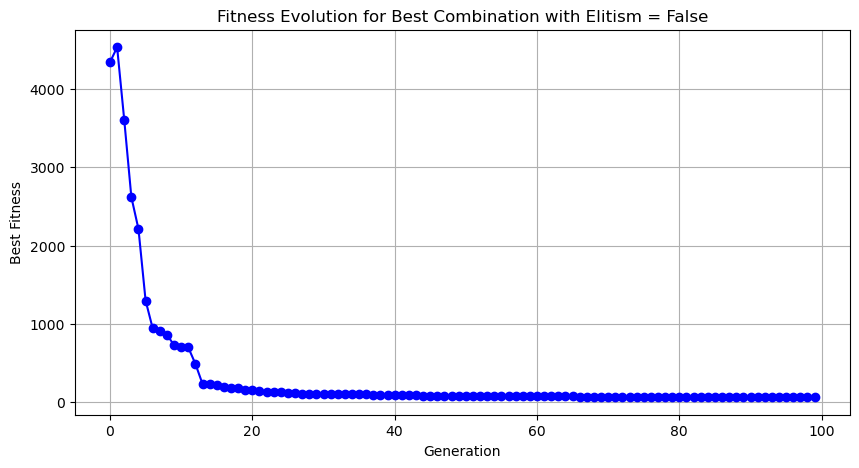

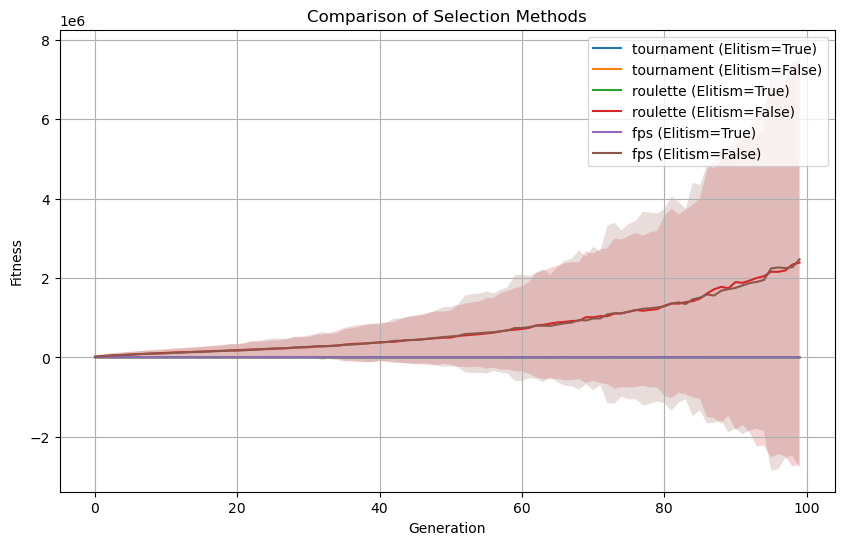

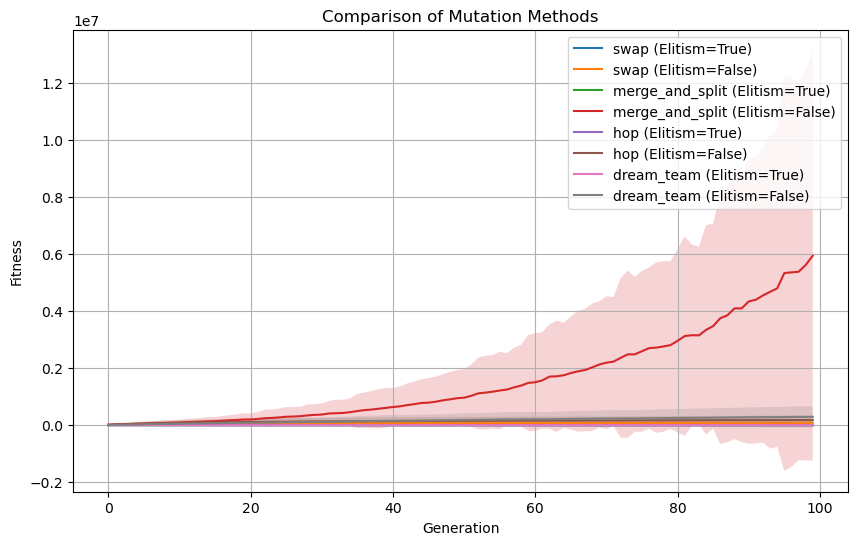

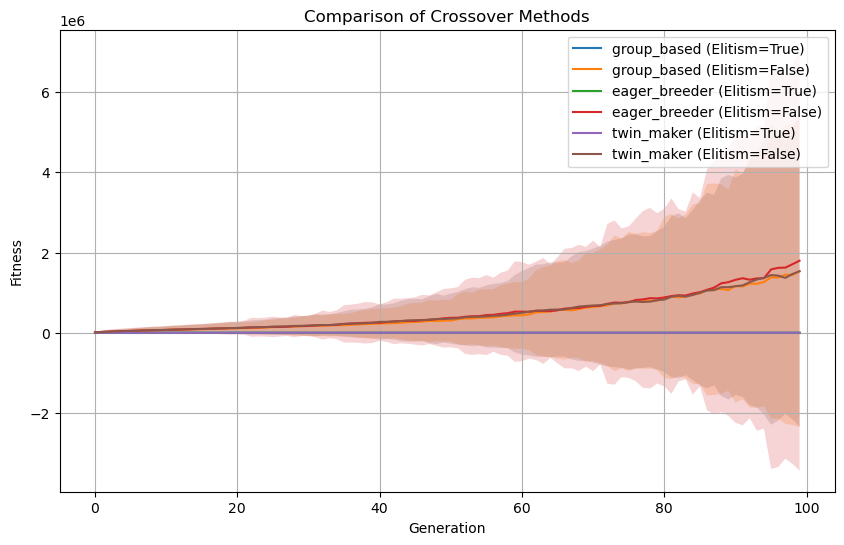

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

# Define all selection, crossover, and mutation methods
selection_methods = {
    "tournament": tournament_selection,
    "roulette": roulette_wheel_selection,
    "fps": fps_selection
}

crossover_methods = {
    "group_based": group_based_crossover,
    "eager_breeder": eager_breeder_crossover,
    "twin_maker": twin_maker_crossover
}

mutation_methods = {
    "swap": swap_mutation,
    "merge_and_split": merge_and_split_mutation,
    "hop": hop_mutation,
    "dream_team": dream_team_mutation
}

# Get all XML files in the 'augerat' directory
folder_path = 'augerat'
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.xml')]
# Initialize dictionaries to store fitness results
elitism_options = [True, False]
selection_fitness_results = {name: {elitism: [] for elitism in elitism_options} for name in selection_methods.keys()}
selection_fitness_histories = {name: {elitism: [] for elitism in elitism_options} for name in selection_methods.keys()}

crossover_fitness_results = {name: {elitism: [] for elitism in elitism_options} for name in crossover_methods.keys()}
crossover_fitness_histories = {name: {elitism: [] for elitism in elitism_options} for name in crossover_methods.keys()}

mutation_fitness_results = {name: {elitism: [] for elitism in elitism_options} for name in mutation_methods.keys()}
mutation_fitness_histories = {name: {elitism: [] for elitism in elitism_options} for name in mutation_methods.keys()}

combination_results = {elitism: {} for elitism in elitism_options}

# Process the grid search and track fitness for each selection method separately
for elitism in elitism_options:
    for selection_name, crossover_name, mutation_name in product(selection_methods, crossover_methods, mutation_methods):
        combination_key = (selection_name, crossover_name, mutation_name)
        combination_results[elitism][combination_key] = []

        for file_path in file_paths:
            distance_matrix, demands, vehicle_capacity = parse_vrp_xml(file_path)

            valid_set = list(range(1, len(distance_matrix)))

            # Initialize the population
            population = Population(
                size=10,
                optim="min",
                sol_size=5,  # Assume 5 vehicles for the routes
                valid_set=valid_set,
                repetition=True
            )

            # Evolve the population
            population.evolve(
                gens=100,          # Number of generations
                select=selection_methods[selection_name],     # Selection function
                crossover=crossover_methods[crossover_name],  # Crossover function
                mutate=mutation_methods[mutation_name],       # Mutation function
                co_p=0.8,          # Crossover probability
                mu_p=0.2,          # Mutation probability
                elitism=elitism    # Elitism
            )

            # Track fitness history for this instance
            fitness_history = population.fitness_history
            average_fitness = np.mean(fitness_history)
            combination_results[elitism][combination_key].append(average_fitness)

            # Track the fitness for the current selection method
            selection_fitness_results[selection_name][elitism].append(average_fitness)
            selection_fitness_histories[selection_name][elitism].append(fitness_history)

            crossover_fitness_results[crossover_name][elitism].append(average_fitness)
            crossover_fitness_histories[crossover_name][elitism].append(fitness_history)

            mutation_fitness_results[mutation_name][elitism].append(average_fitness)
            mutation_fitness_histories[mutation_name][elitism].append(fitness_history)

# Calculate average fitness across all combinations for each selection method
for elitism in elitism_options:
    average_selection_fitness = {name: np.mean(fitness_list[elitism]) for name, fitness_list in selection_fitness_results.items() if fitness_list[elitism]}

    # Print the average fitness for each selection method
    for selection_name, avg_fitness in average_selection_fitness.items():
        print(f"Elitism: {elitism}, Selection Method: {selection_name}, Average Fitness: {avg_fitness}")

    # Calculate average fitness across all combinations for each mutation method
    average_mutation_fitness = {name: np.mean(fitness_list[elitism]) for name, fitness_list in mutation_fitness_results.items() if fitness_list[elitism]}

    # Print the average fitness for each mutation method
    for mutation_name, avg_fitness in average_mutation_fitness.items():
        print(f"Elitism: {elitism}, Mutation Method: {mutation_name}, Average Fitness: {avg_fitness}")

    # Calculate average fitness across all combinations for each crossover method
    average_crossover_fitness = {name: np.mean(fitness_list[elitism]) for name, fitness_list in crossover_fitness_results.items() if fitness_list[elitism]}

    # Print the average fitness for each crossover method
    for crossover_name, avg_fitness in average_crossover_fitness.items():
        print(f"Elitism: {elitism}, Crossover Method: {crossover_name}, Average Fitness: {avg_fitness}")

    # Calculate average fitness across all instances for each combination
    average_results = [(key, np.mean(fitness_list)) for key, fitness_list in combination_results[elitism].items()]

    # Sort results based on the average fitness
    average_results.sort(key=lambda x: x[1])
    best_combination, best_average_fitness = average_results[0]

    print(f"\nBest Combination for Elitism = {elitism}:")
    print(f"Selection: {best_combination[0]}, Crossover: {best_combination[1]}, Mutation: {best_combination[2]}, Average Fitness: {best_average_fitness}")

    # Visualize fitness evolution for the best combination
    best_fitness_histories = []
    for file_path in file_paths:
        distance_matrix, demands, vehicle_capacity = parse_vrp_xml(file_path)
        valid_set = list(range(1, len(distance_matrix)))

        population = Population(
            size=10,
            optim="min",
            sol_size=5,
            valid_set=valid_set,
            repetition=True
        )

        population.evolve(
            gens=100,
            select=selection_methods[best_combination[0]],
            crossover=crossover_methods[best_combination[1]],
            mutate=mutation_methods[best_combination[2]],
            co_p=0.8,
            mu_p=0.2,
            elitism=elitism
        )

        best_fitness_histories.append(population.fitness_history)

    min_length = min(len(history) for history in best_fitness_histories)
    truncated_histories = [history[:min_length] for history in best_fitness_histories]
    average_fitness_history = np.mean(truncated_histories, axis=0)

    plot_fitness_evolution(average_fitness_history, f'Fitness Evolution for Best Combination with Elitism = {elitism}')

# Plot the comparison of selection methods
def plot_selection_comparison(fitness_histories, labels, title, filename):
    plt.figure(figsize=(10, 6))

    for label in labels:
        if fitness_histories[label]:  # Ensure the fitness history is not empty
            for elitism in elitism_options:
                if fitness_histories[label][elitism]:
                    avg_fitness = np.mean(fitness_histories[label][elitism], axis=0)
                    std_fitness = np.std(fitness_histories[label][elitism], axis=0)
                    generations = np.arange(len(avg_fitness))
                    plt.plot(generations, avg_fitness, label=f"{label} (Elitism={elitism})")
                    plt.fill_between(generations, avg_fitness - std_fitness, avg_fitness + std_fitness, alpha=0.2)

    plt.title(title)
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

plot_selection_comparison(selection_fitness_histories, list(selection_methods.keys()), 'Comparison of Selection Methods', 'selection_comparison.png')
plot_selection_comparison(mutation_fitness_histories, list(mutation_methods.keys()), 'Comparison of Mutation Methods', 'mutation_comparison.png')
plot_selection_comparison(crossover_fitness_histories, list(crossover_methods.keys()), 'Comparison of Crossover Methods', 'crossover_comparison.png')


Selection Method: tournament, Average Fitness: 886.9037220024909
Selection Method: roulette, Average Fitness: 3005.368104028715
Selection Method: fps, Average Fitness: 2849.6796764964724
Mutation Method: swap, Average Fitness: 2451.8257609357806
Mutation Method: merge_and_split, Average Fitness: 2070.360210485225
Mutation Method: hop, Average Fitness: 3003.500282312186
Mutation Method: dream_team, Average Fitness: 1463.582416303715
Crossover Method: group_based, Average Fitness: 2490.0468397448394
Crossover Method: eager_breeder, Average Fitness: 2102.762123305492
Crossover Method: twin_maker, Average Fitness: 2149.1425394773482

Best Combination:
Selection: tournament, Crossover: twin_maker, Mutation: merge_and_split, Average Fitness: 116.42622835904659


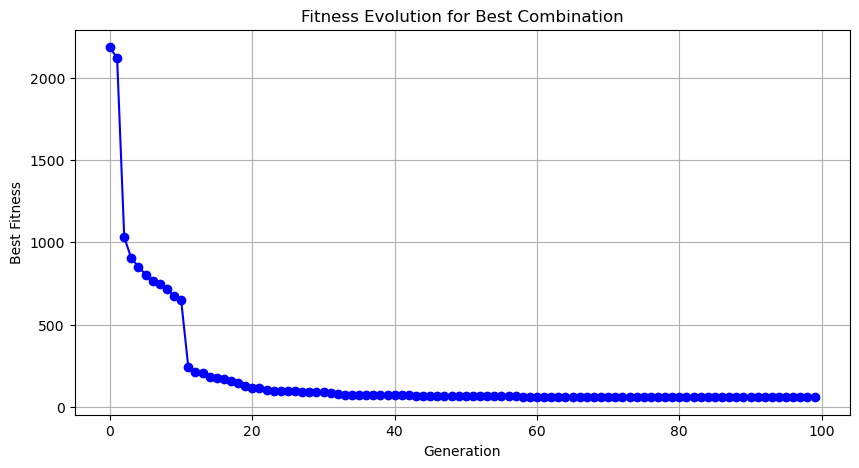

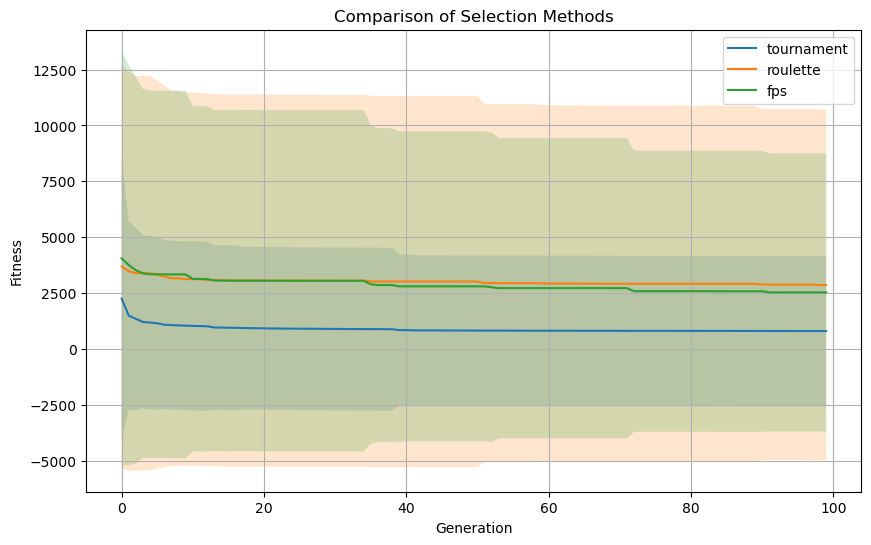

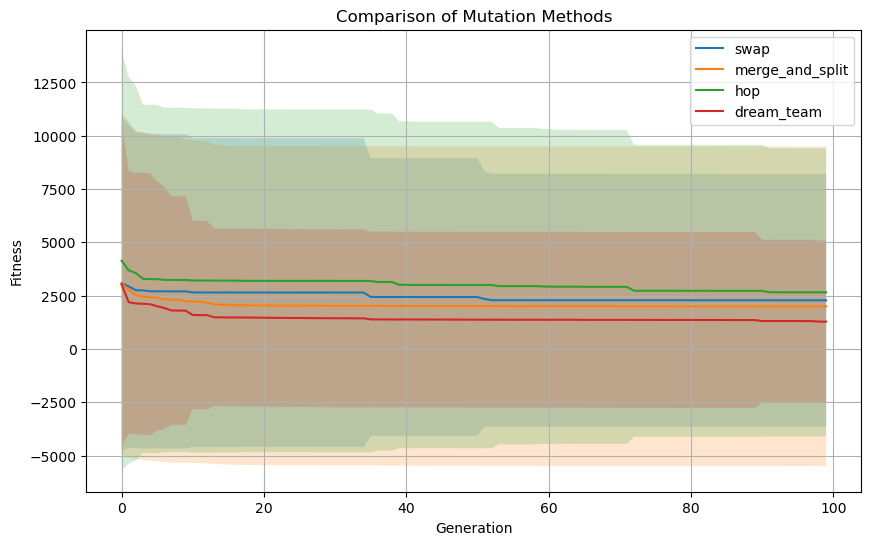

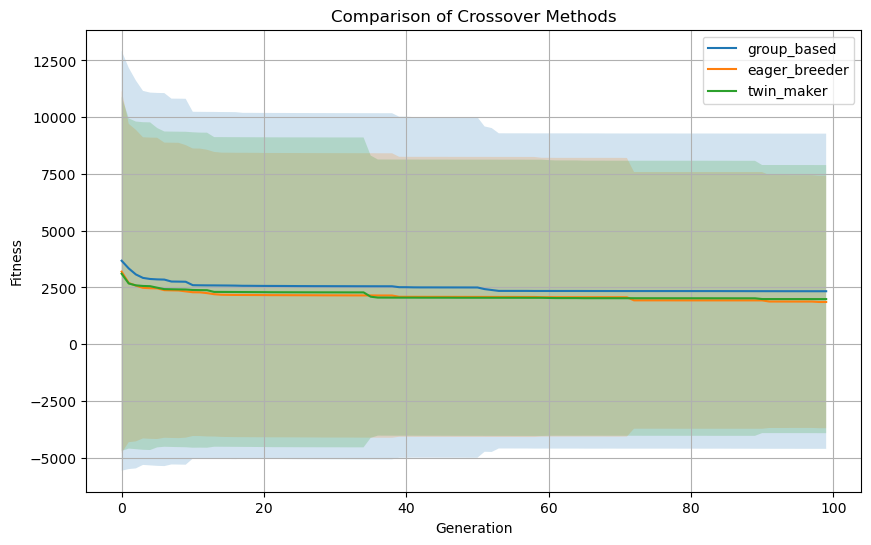

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

# Define all selection, crossover, and mutation methods
selection_methods = {
    "tournament": tournament_selection,
    "roulette": roulette_wheel_selection,
    "fps": fps_selection
}

crossover_methods = {
    "group_based": group_based_crossover,
    "eager_breeder": eager_breeder_crossover,
    "twin_maker": twin_maker_crossover
}

mutation_methods = {
    "swap": swap_mutation,
    "merge_and_split": merge_and_split_mutation,
    "hop": hop_mutation,
    "dream_team": dream_team_mutation
}

# Get all XML files in the 'augerat' directory
folder_path = 'augerat'
file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.xml')]
# Initialize a dictionary to store the average fitness for each selection method
selection_fitness_results = {name: [] for name in selection_methods.keys()}
selection_fitness_histories = {name: [] for name in selection_methods.keys()}

crossover_fitness_results = {name: [] for name in crossover_methods.keys()}
crossover_fitness_histories = {name: [] for name in crossover_methods.keys()}

mutation_fitness_results = {name: [] for name in mutation_methods.keys()}
mutation_fitness_histories = {name: [] for name in mutation_methods.keys()}

combination_results = {}

# Process the grid search and track fitness for each selection method separately
for selection_name, crossover_name, mutation_name in product(selection_methods, crossover_methods, mutation_methods):
    combination_key = (selection_name, crossover_name, mutation_name)
    combination_results[combination_key] = []

    for file_path in file_paths:
        distance_matrix, demands, vehicle_capacity = parse_vrp_xml(file_path)

        valid_set = list(range(1, len(distance_matrix)))

        # Initialize the population
        population = Population(
            size=10,
            optim="min",
            sol_size=5,  # Assume 5 vehicles for the routes
            valid_set=valid_set,
            repetition=True
        )

        # Evolve the population
        population.evolve(
            gens=100,          # Number of generations
            select=selection_methods[selection_name],     # Selection function
            crossover=crossover_methods[crossover_name],  # Crossover function
            mutate=mutation_methods[mutation_name],       # Mutation function
            co_p=0.8,          # Crossover probability
            mu_p=0.2,          # Mutation probability
            elitism=True       # Elitism to keep the best individual
        )

        # Track fitness history for this instance
        fitness_history = population.fitness_history
        average_fitness = np.mean(fitness_history)
        combination_results[combination_key].append(average_fitness)

        # Track the fitness for the current selection method
        selection_fitness_results[selection_name].append(average_fitness)
        selection_fitness_histories[selection_name].append(fitness_history)

        crossover_fitness_results[crossover_name].append(average_fitness)
        crossover_fitness_histories[crossover_name].append(fitness_history)

        mutation_fitness_results[mutation_name].append(average_fitness)
        mutation_fitness_histories[mutation_name].append(fitness_history)

# Calculate average fitness across all combinations for each selection method
average_selection_fitness = {name: np.mean(fitness_list) for name, fitness_list in selection_fitness_results.items() if fitness_list}

# Print the average fitness for each selection method
for selection_name, avg_fitness in average_selection_fitness.items():
    print(f"Selection Method: {selection_name}, Average Fitness: {avg_fitness}")

# Calculate average fitness across all combinations for each mutation method
average_mutation_fitness = {name: np.mean(fitness_list) for name, fitness_list in mutation_fitness_results.items() if fitness_list}

# Print the average fitness for each mutation method
for mutation_name, avg_fitness in average_mutation_fitness.items():
    print(f"Mutation Method: {mutation_name}, Average Fitness: {avg_fitness}")

# Calculate average fitness across all combinations for each crossover method
average_crossover_fitness = {name: np.mean(fitness_list) for name, fitness_list in crossover_fitness_results.items() if fitness_list}

# Print the average fitness for each crossover method
for crossover_name, avg_fitness in average_crossover_fitness.items():
    print(f"Crossover Method: {crossover_name}, Average Fitness: {avg_fitness}")

# Calculate average fitness across all instances for each combination
average_results = [(key, np.mean(fitness_list)) for key, fitness_list in combination_results.items()]

# Sort results based on the average fitness
average_results.sort(key=lambda x: x[1])
best_combination, best_average_fitness = average_results[0]

print("\nBest Combination:")
print(f"Selection: {best_combination[0]}, Crossover: {best_combination[1]}, Mutation: {best_combination[2]}, Average Fitness: {best_average_fitness}")

# Visualize fitness evolution for the best combination
best_fitness_histories = []
for file_path in file_paths:
    distance_matrix, demands, vehicle_capacity = parse_vrp_xml(file_path)
    valid_set = list(range(1, len(distance_matrix)))

    population = Population(
        size=10,
        optim="min",
        sol_size=5,
        valid_set=valid_set,
        repetition=True
    )

    population.evolve(
        gens=100,
        select=selection_methods[best_combination[0]],
        crossover=crossover_methods[best_combination[1]],
        mutate=mutation_methods[best_combination[2]],
        co_p=0.8,
        mu_p=0.2,
        elitism=True
    )

    best_fitness_histories.append(population.fitness_history)

min_length = min(len(history) for history in best_fitness_histories)
truncated_histories = [history[:min_length] for history in best_fitness_histories]
average_fitness_history = np.mean(truncated_histories, axis=0)

plot_fitness_evolution(average_fitness_history, 'Fitness Evolution for Best Combination')

# Plot the comparison of selection methods
def plot_selection_comparison(fitness_histories, labels, title, filename):
    plt.figure(figsize=(10, 6))

    for label in labels:
        if fitness_histories[label]:  # Ensure the fitness history is not empty
            avg_fitness = np.mean(fitness_histories[label], axis=0)
            std_fitness = np.std(fitness_histories[label], axis=0)
            generations = np.arange(len(avg_fitness))
            plt.plot(generations, avg_fitness, label=label)
            plt.fill_between(generations, avg_fitness - std_fitness, avg_fitness + std_fitness, alpha=0.2)

    plt.title(title)
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

plot_selection_comparison(selection_fitness_histories, list(selection_methods.keys()), 'Comparison of Selection Methods', 'selection_comparison.png')
plot_selection_comparison(mutation_fitness_histories, list(mutation_methods.keys()), 'Comparison of Mutation Methods', 'mutation_comparison.png')
plot_selection_comparison(crossover_fitness_histories, list(crossover_methods.keys()), 'Comparison of Crossover Methods', 'crossover_comparison.png')
